**Title**: How well can we predict credit card default?

**Introduction**: The data set we are using is an aggregate of credit card data from various individuals in Taiwan that includes variables such as sex, education, age, whether or not they defaulted on a payment and others. Default on payment means that an individual did not pay their credit card bills. Our question for this data analytics project is;

How accurately can Education and Age predict the likelihood of an individual defaulting on their next credit card payment? 

Why did we choose these predictor variables over the numerous other variables in the data set? Our first objective was to eliminate those variables we felt did not contribute at all to the probability of default payments, such as sex. Next, we did some external research and found that of the remaining variables, age and education matched the best predictors of default probability from our external research. Thus, we will build our classification model on these two predictor models to determine the accuracy to which we can predict default probability. 

The dataset we will be using has 25 variables and 30002 records. The data set includes the variables we mentioned above and others such as the bill amounts each client has as well as the payments each client has made towards those bill amounts. Sex is categorized using 1’s (Male) and 2’s (Female). Education is classified with numbers 1 (Graduate School), 2 (University), 3 (High School), and 4 (Others). Age is simply the numeric value of the individual's age. The default payment variable is represented by 1’s (Yes, did default) and 2’s (No, did not default). 

We are interested in this question since credit card default is a real problem in the world, with credit card delinquency rates increasing by 0.180%  year on year since 2018 in Taiwan (CEIC, 2020). Using the models we create, we can determine the risk of lending credit to an individual with a high risk of default and therefore protect the creditors.

**Methods**: We will be including the following columns; Education, Age and Default payment next month. We will conduct our data analysis using classification. Our classification will be done by creating a test set and a training set. Following this, we will begin to create a model that will tune the K nearest neighbors value we should use and a recipe that uses the straight line (“rectangular”) method to predict classifications. Following this we will fold the training set (most likely 10 times) to allow for a relatively accurate prediction of the K nearest neighbors value we should use. Using this, we will move forward with applying our model to our test set and predicting the classifications. 

We will create a bar chart that will depict the proportion of how many classifications were correctly predicted next to another bar that depicts the proportion of classifications that were incorrectly predicted. 

**Expected outcomes and significance**: We expect to find that there is a correlation between the variables education, age and the classification of whether the individual defaulted. We expect to find that as education levels increase, probability of default decreases. We also expect to find that as age increases, there is a general decrease in the probability of default. Findings like this can allow credit card companies to apply higher late/default rates to customers who are more likely to default on payments based on our model and classification. Future questions would be;
How can we make our predictions more accurate?
Is it ethical to change rates/interest on individuals who have been classified by a model to be more likely to default?



In [21]:
library(tidyverse)
library(repr)
library(tidymodels)
library(readxl)
options(repr.plot.width=10, repr.plot.height=6, repr.matrix.max.rows = 6)



In [22]:
set.seed(1234)
temporary <- tempfile()
download.file("https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls", temporary)
credit_card <- read_excel(temporary, skip = 1)
colnames(credit_card)[25] <- "default_payment_next_month"
tidied_credit_card <- credit_card %>% 
                    select(EDUCATION, AGE, default_payment_next_month) %>%
                    mutate(default_payment_next_month = as_factor(default_payment_next_month))
credit_split <- initial_split(tidied_credit_card, prop = 0.75, strata = default_payment_next_month)
credit_train <- training(credit_split)
credit_test <- testing(credit_split)
credit_card

ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,⋯,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default_payment_next_month
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,20000,2,2,1,24,2,2,-1,-1,⋯,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,-1,2,0,0,⋯,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,⋯,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
29998,30000,1,2,2,37,4,3,2,-1,⋯,20878,20582,19357,0,0,22000,4200,2000,3100,1
29999,80000,1,3,1,41,1,-1,0,0,⋯,52774,11855,48944,85900,3409,1178,1926,52964,1804,1
30000,50000,1,2,1,46,0,0,0,0,⋯,36535,32428,15313,2078,1800,1430,1000,1000,1000,1


In [23]:
set.seed(1234)
credit_summarize <- credit_train %>%
                    group_by(EDUCATION, AGE, default_payment_next_month) %>%
                    summarize(n = n())
credit_summarize

`summarise()` regrouping output by 'EDUCATION', 'AGE' (override with `.groups` argument)



EDUCATION,AGE,default_payment_next_month,n
<dbl>,<dbl>,<fct>,<int>
0,28,0,1
0,30,0,1
0,35,0,1
⋮,⋮,⋮,⋮
6,57,0,1
6,59,0,1
6,66,0,2


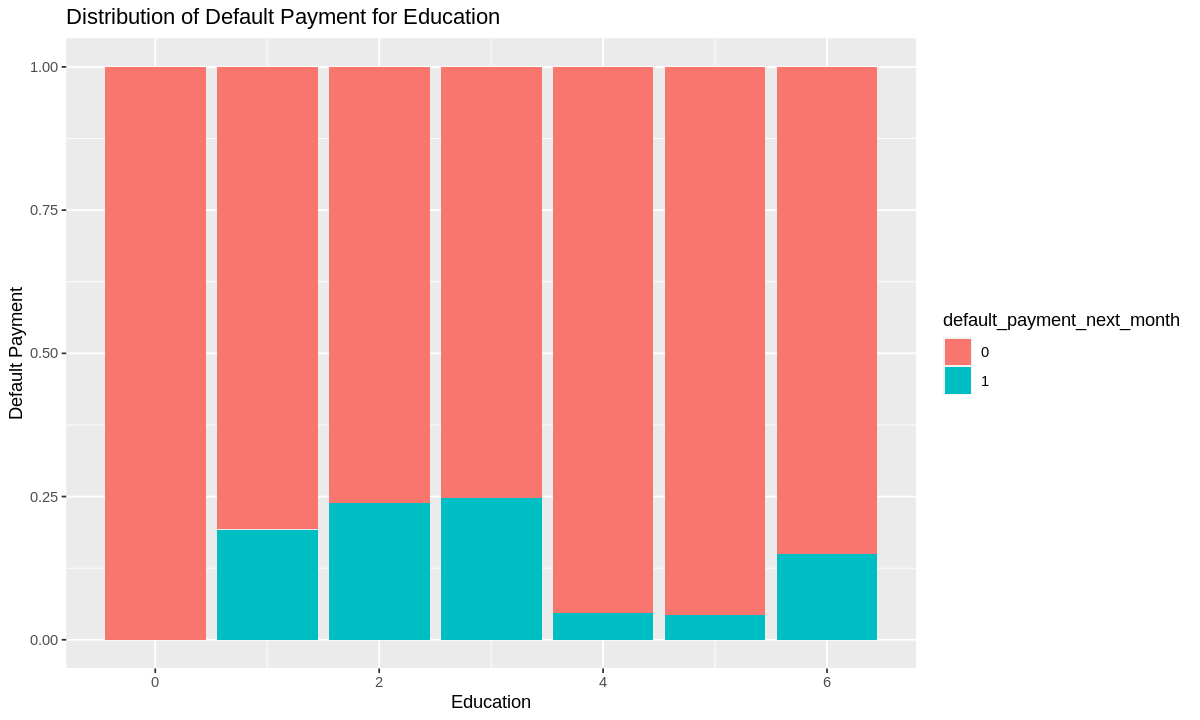

In [24]:
set.seed(1234)
credit_education_graph <- ggplot(credit_summarize, aes(x = EDUCATION, y = n, fill = default_payment_next_month)) +
                geom_bar(stat = "identity", position = "fill") +
                labs(x = "Education", y = "Default Payment", title = "Distribution of Default Payment for Education")
credit_education_graph

Figure 1: Distrubution of Default Payment for Education. This graph shows the distribution between each education level and the number of default payments 1 (Yes) and 0 (No). The graph shows that Education levels 2 and 3 have the highest default rate.

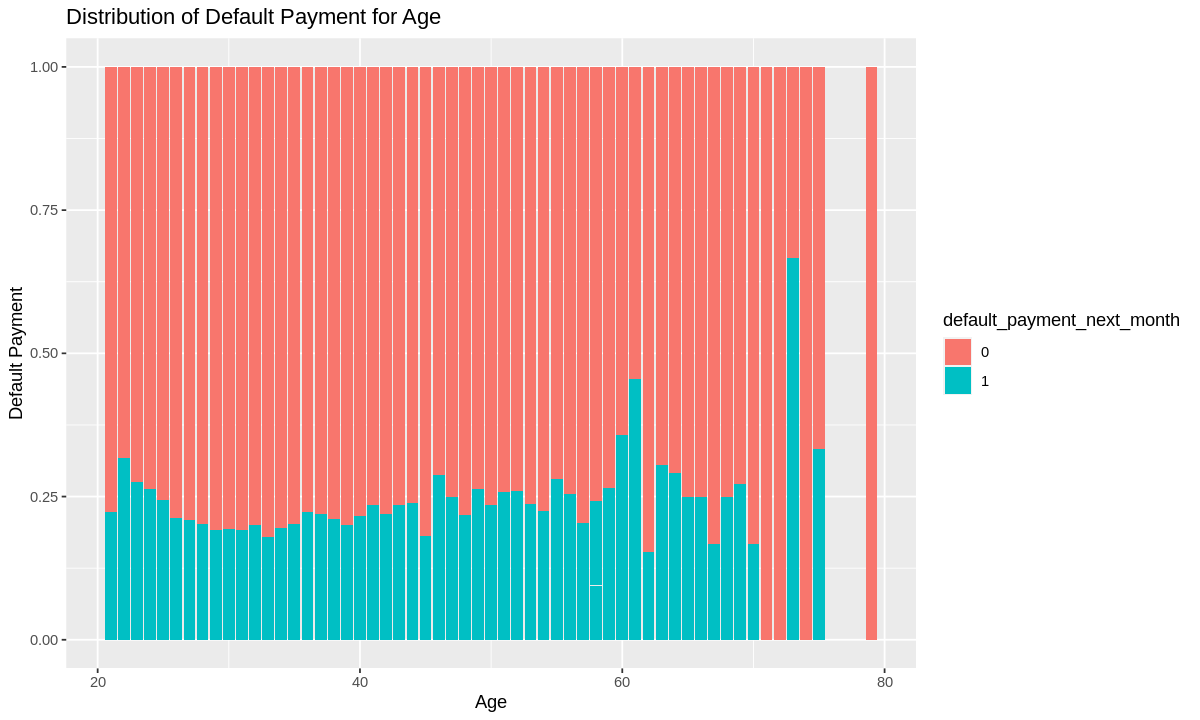

In [27]:
set.seed(1234)
credit_sex_graph <- ggplot(credit_summarize, aes(x = AGE, y = n, fill = default_payment_next_month)) +
                geom_bar(stat = "identity", position = "fill") +
                labs(x = "Age", y = "Default Payment", title = "Distribution of Default Payment for Age")
credit_sex_graph

Figure 2: Distrubution of Default Payment for Age. This graph shows the distribution between each age and the number of default payments 1 (Yes) and 0 (No). The graph shows that older ages around 60+ have a higher rate of default payment.

In [28]:
set.seed(1234)
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
      set_engine("kknn") %>%
      set_mode("classification")
credit_recipe <- recipe(default_payment_next_month ~ EDUCATION + AGE, data = credit_train) %>%
                step_scale(all_predictors()) %>%
                step_center(all_predictors())
credit_vfold <- vfold_cv(credit_train, v = 5, strata = default_payment_next_month)
gridvals = tibble(neighbors = seq(1,50))
credit_fit <- workflow() %>%
      add_recipe(credit_recipe) %>%
      add_model(knn_spec) %>%
      tune_grid(resamples = credit_vfold, grid = 100) %>%
        collect_metrics()
credit_fit
#credit_test_predictions <- predict(credit_train, credit_test)
#credit_test_predictions


neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.6560439,5,0.011233280,Model01
1,roc_auc,binary,0.4990204,5,0.002520661,Model01
2,accuracy,binary,0.6446649,5,0.017410578,Model02
⋮,⋮,⋮,⋮,⋮,⋮,⋮
14,roc_auc,binary,0.5196971,5,0.005036749,Model14
15,accuracy,binary,0.7746670,5,0.001041013,Model15
15,roc_auc,binary,0.5223240,5,0.005125430,Model15


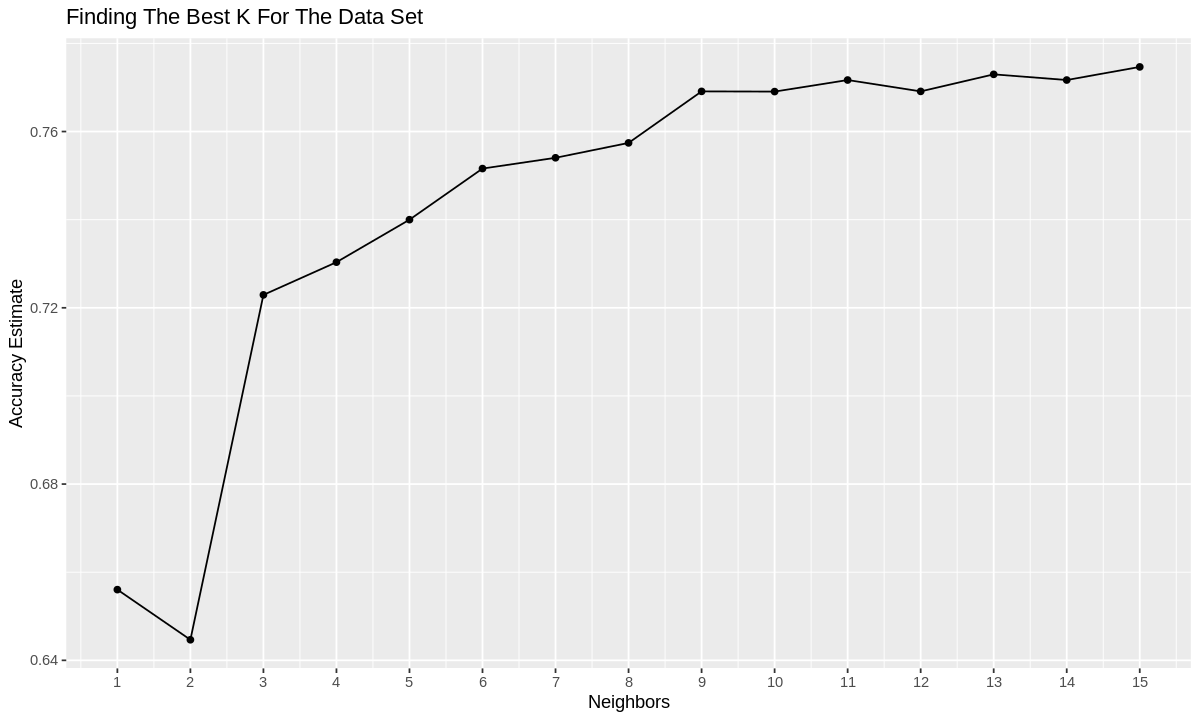

In [41]:
set.seed(1234)
accuracies <- credit_fit %>% 
      filter(.metric == "accuracy")

accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean))+
      geom_point() +
      geom_line() +
      labs(x = "Neighbors", y = "Accuracy Estimate", title = "Finding The Best K For The Data Set") +
      scale_x_continuous(breaks = seq(0, 20, by = 1))    # adjusting the x-axis
      #scale_y_continuous(limits = c(0.4, 1.0)) # adjusting the y-axis
accuracy_versus_k

Figure 3: Finding The Best K For The Data Set. The graph shows that the K with the highest accuracy estimate is 15, which is the K we chose.

In [30]:
set.seed(1234)
knn_final <- nearest_neighbor(weight_func = "rectangular", neighbors = 15) %>%
      set_engine("kknn") %>%
      set_mode("classification")
credit_final = workflow() %>%
      add_recipe(credit_recipe) %>%
      add_model(knn_final) %>%
      fit(data = credit_train)


In [31]:
set.seed(1234)
credit_predictions = predict(credit_final, credit_test) %>%
      bind_cols(credit_test)
credit_metrics <- credit_predictions %>%
        metrics(truth = default_payment_next_month, estimate = .pred_class) 
credit_conf_mat <- credit_predictions %>%
        conf_mat(truth = default_payment_next_month, estimate = .pred_class) 
credit_predictions
credit_metrics
credit_conf_mat

.pred_class,EDUCATION,AGE,default_payment_next_month
<fct>,<dbl>,<dbl>,<fct>
0,2,24,1
0,1,27,0
0,1,30,0
⋮,⋮,⋮,⋮
0,2,34,1
0,3,41,1
0,2,46,1


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.77253333
kap,binary,-0.00238834


          Truth
Prediction    0    1
         0 5779 1644
         1   62   15

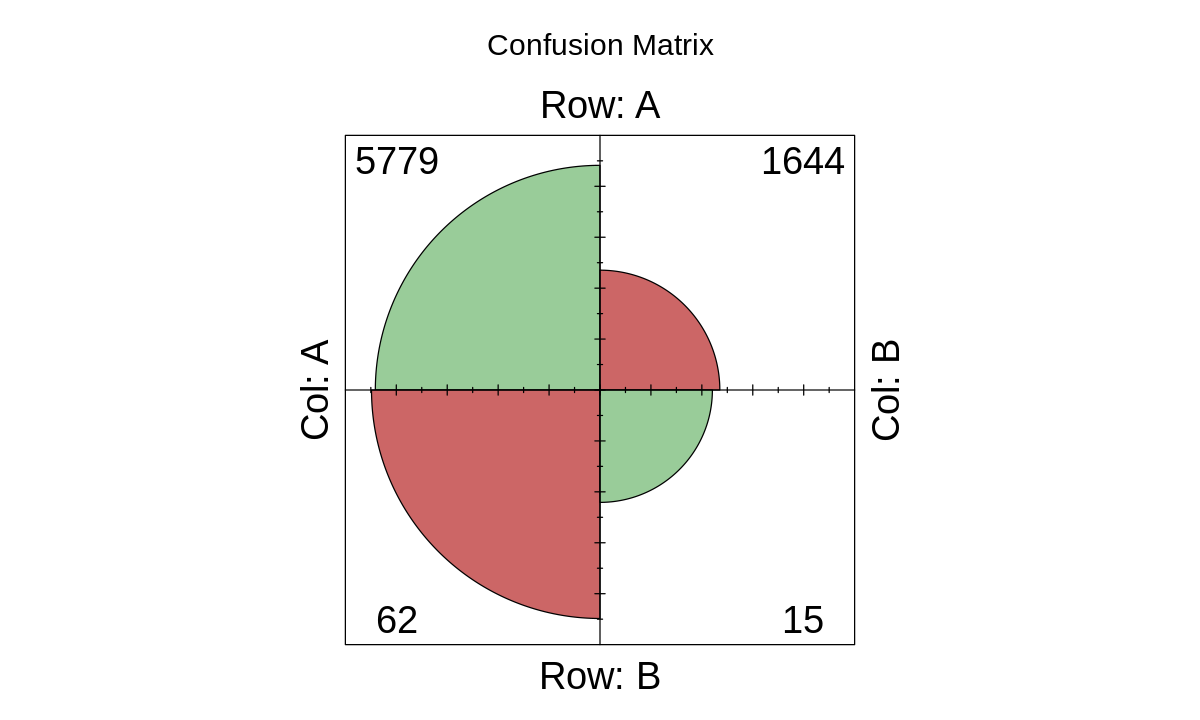

In [58]:
ctable <- as.table(matrix(c(5779, 1644, 62, 15), nrow = 2, byrow = TRUE))
fourfoldplot(ctable, color = c("#99CC99", "#CC6666"),
             conf.level = 0, margin = 1, main = "Confusion Matrix")